In [1]:
import numpy as np
from nibabel.testing import data_path
import nibabel as nib

import keras
from keras import backend as K
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
from IPython.display import display

import nilearn
from nilearn import plotting
from nilearn import image
from nilearn import datasets

from keras_tqdm import TQDMNotebookCallback

# Get dataset with nilearn function
# if not downloaded, will download. If already downloaded, will use local version
dataset = nilearn.datasets.fetch_cobre(n_subjects=146, data_dir="C:\\Users\\Imagi\\Documents\\5850\\datasets", url=None, verbose=1)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\npyio.py:2315: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [2]:
phenotypes = dataset["phenotypic"]
confounds = dataset["confounds"]
file_paths = dataset["func"]
phenotypes.sort(0) #sort by column corresponding to patient number
file_paths.sort() #sort file names by alphabetical order, which will result in sorting by patient number
confounds.sort()

#file_paths is now a regular python list of the file paths to the fmri scans
#phenotypes is now a np.recarray of np.records storing patient info
# get just the diagnosis information from the phenotypes
diagnosis = phenotypes['diagnosis']
diagnosis_converted = []
#this stem is necessary to convert np.byte array into strings, 
#and then fit those strings into 2 categories:
#Schizophrenia or no Schizophrenia
for item in diagnosis:
    s = item.decode('UTF-8')
    if s != "None":
        diagnosis_converted.append(float(1))   #person has schizophrenia
    else:
        diagnosis_converted.append(float(0))   #person doesn't have schizophrenia

del diagnosis_converted[74] # item 74 is a messed up scan with different dimensions
del file_paths[74]          # so it needs to be removed
del confounds[74]

Y = np.array(diagnosis_converted)
display(Y.shape)

(145,)

In [3]:
# this is a brain anatomical atlas template, that gives us brain reigons with their labels
msdl_atlas_dataset = nilearn.datasets.fetch_atlas_msdl(data_dir="C:\\Users\\Imagi\\Documents\\5850")

from nilearn import image
from nilearn import input_data
from sklearn.externals.joblib import Memory   # A "memory" to avoid recomputation
mem = Memory('nilearn_cache')

# mask the data, used the atlas template as the mask img.
masker = input_data.NiftiMapsMasker(
    msdl_atlas_dataset.maps, resampling_target="maps", detrend=True,
    low_pass=.5, high_pass=0.01, t_r=2.0, standardize=True,
    memory='nilearn_cache', memory_level=1, verbose=0)
masker.fit()
display("i got here")

'i got here'

In [4]:
# for each of our fmri scams, compute confounds, transform them into mask, and append
# to time series list
subject_time_series = []
for file_path, confound in zip(file_paths, confounds):

    # Computing some confounds
    hv_confounds = mem.cache(image.high_variance_confounds)(
        file_path, n_confounds=10)

    region_ts = masker.transform(file_path, 
                                 confounds=[hv_confounds, confound])
    subject_time_series.append(region_ts)

display("i got here")

C:\ProgramData\Anaconda3\lib\site-packages\nilearn\image\resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
C:\ProgramData\Anaconda3\lib\site-packages\nilearn\signal.py:180: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to nyquist frequency). It has been lowered to 1.00 (nyquist frequency).
  'frequency).' % (btype, wn))


________________________________________________________________________________
[Memory] Calling nilearn.image.image.high_variance_confounds...
high_variance_confounds('C:\\Users\\Imagi\\Documents\\5850\\datasets\\cobre\\fmri_0040076.nii.gz', n_confounds=10)
__________________________________________high_variance_confounds - 0.9s, 0.0min


C:\ProgramData\Anaconda3\lib\site-packages\nilearn\image\resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
C:\ProgramData\Anaconda3\lib\site-packages\nilearn\signal.py:180: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to nyquist frequency). It has been lowered to 1.00 (nyquist frequency).
  'frequency).' % (btype, wn))
C:\ProgramData\Anaconda3\lib\site-packages\nilearn\image\resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
C:\ProgramData\Anaconda3\lib\site-packages\nilearn\signal.py:180: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to nyquist frequency). It has been lowered to 1.00 (nyquist frequency).
  'frequency).' % (btype, wn))
C:\ProgramData\Anaconda3\lib\site-pack

'i got here'

In [5]:
#Here is where I prepare the data for input
X = np.array(subject_time_series)
fullx = X.astype('float32').reshape(X.shape+(1,))

#one-hot encoding
Y = keras.utils.to_categorical(Y, len(np.unique(Y))) #one hot encoding

x_train = fullx[:110]
x_test = fullx[110:]
y_train = Y[:110]
y_test = Y[110:]
print(x_train.shape)
print(y_train.shape)
print(y_test.shape)
print(x_test.shape)

(110, 150, 39, 1)
(110, 2)
(35, 2)
(35, 150, 39, 1)


In [39]:
#time to finally build a model and test it!
model1 = keras.Sequential()
model1.add(keras.layers.Conv2D(256, kernel_size = (2,2), activation = 'relu'
                              ,input_shape=[150,39,1]))
#model1.add(keras.layer.MaxPooling2D(pool_size=(2,2)))
model1.add(keras.layers.BatchNormalization(momentum=0.8))
model1.add(keras.layers.Conv2D(128, (8,8), activation='relu'))
model1.add(keras.layers.BatchNormalization(momentum=0.8))
model1.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model1.add(keras.layers.Dropout(0.6))
model1.add(keras.layers.Flatten())
model1.add(keras.layers.Dense(128, activation='relu'))
model1.add(keras.layers.Dropout(0.3))
model1.add(keras.layers.Dense(y_train.shape[1], activation='softmax')) #y_train.shape[1]??

model1.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.0001),  
              metrics=['accuracy']) #0.0001
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 149, 38, 256)      1280      
_________________________________________________________________
batch_normalization_14 (Batc (None, 149, 38, 256)      1024      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 142, 31, 128)      2097280   
_________________________________________________________________
batch_normalization_15 (Batc (None, 142, 31, 128)      512       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 71, 15, 128)       0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 71, 15, 128)       0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 136320)            0         
__________

In [40]:
#model1.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
batch_size = 10
epochs = 20
validation_split = 0.1
display("running...")

history = model1.fit(x_train, y_train, batch_size = batch_size, epochs = epochs
                     , verbose = 0, validation_split = validation_split, callbacks=[TQDMNotebookCallback()])

print("Finished")

'running...'

Finished


In [41]:
print('Accuracy:',model1.evaluate(x_test,y_test)[1]*100.0,'%')

35/35 [==============================] - 13s 362ms/step
Accuracy: 45.714285714285715 %


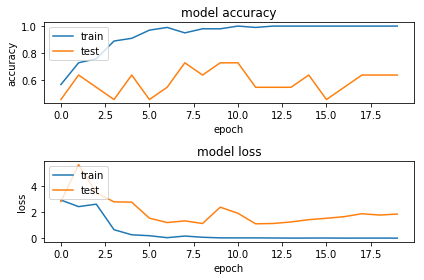

In [42]:
plt.figure()
plt.subplot(211)

#summarize accuracy history
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')

#summarize loss history
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')


plt.tight_layout()
plt.show()

## Evaluation
This was the best *true* network I got out of the bunch. I call it a true network because it exhibited traits of learning and simply over-fit to the training data and didn't generalize well.

More things to try if I had extra time would be:
* carefully varying the learning rate to see if I could get better generalization
* trying to add a recurrency layer. I made an attempt but it was quickly getting to complicated, and I needed to move on
* more preprocessing
* messing with the kernel sizes a bit more than I did. I tended to focus more on the number of neurons in the layer as opposed to the kernel size.